In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError,RootMeanSquaredError, MeanAbsolutePercentageError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, Dropout

import keras_tuner
import keras
from keras import layers

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.13.1


In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(tf.__version__)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8276867659173616602
xla_global_id: -1
]
2.13.1
Device mapping: no known devices.
Num GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

## Data Preprocessing

In [7]:
## For Step 1.1: downloading of stock prices. only 1 stock
def extract_all(stocks: list, 
                start: dt.datetime, 
                end: dt.datetime):
            
    def extract_single_ticker(ticker):
           
        return(yf
               .download(ticker, 
                               start,
                               end)
               )
    interim_df = map(extract_single_ticker, stocks) # applies the extract_single_ticker function to the stocks (list of tickers)
    
    return(pd
           .concat(interim_df,
                  keys = stocks,
                  names = ["ticker", "date"]
                 )
          )
    

    
    ## For Step 1.2: converting multiindex DF long format to singleindex wide format
def multiindex_to_wide(stock_MI: pd.DataFrame):
    
    stock_wide =\
    (
        stock_MI['Adj Close'].reset_index()\
            .pivot(index = 'date',
                columns = 'ticker',
                values = 'Adj Close')            
    )
    return stock_wide
    
tickers = ['^GSPC']
start = dt.datetime(2013, 1, 1)
end = dt.datetime(2024, 10, 6)


gspc = extract_all(stocks = tickers,
                   start = start,
                   end = end)

gspc = multiindex_to_wide(gspc)
gspc.index = gspc.index.rename('Date')

[*********************100%%**********************]  1 of 1 completed


In [8]:
# Load Data and set DatetimeIndex
df = pd.read_csv("combined_data.csv").drop(labels = ['Sentiment Text'], axis = 1)
df.index = pd.to_datetime(df['Date'])


# Join SPY data
df = pd.merge(left = df, right = gspc, how = 'left', left_index = True, right_index = True)
df.loc['2014-01-01', '^GSPC'] = 1848.36 # fill with 31st Dec 'GSPC' adjusted close
df['^GSPC'] = df['^GSPC'].ffill(axis = 0)  # ffill for SPY from previous row (day)


# Resample for monthly data
df['Date'] = pd.to_datetime(df['Date']).map(datetime.datetime.timestamp)
df = df.resample(rule = 'BMS').first()

# cosine transformation to timestamp in seconds, to retain any cyclical / seasonality property
# See https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/ 
# how to feature time stamp to get month_cos
def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))
df["month_cos"] = cos_transformer(12).fit_transform(df)['Date']

# Drop the date column because its represented as "month_cos" as feature
df = df.drop(['Date'], axis = 1)


# Split data into training, validation and test set
len_df = len(df)
train_df = df[0:int(len_df*0.8)]
val_df = df[int(len_df*0.8):int(len_df*0.9)]
test_df = df[int(len_df*0.9):]


# Preprocessing to make data more resemble of normal distribution.
# yeo-johnson because it allows for negative values to be transformed
# alternatively, use MinMaxScaler to make values 0 and 1 to make training dor deep learning model faster
scaler = PowerTransformer(method='yeo-johnson')
scaler.fit(train_df)  # fit only on training set to prevent leakage

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])


print(train_df.shape, val_df.shape, test_df.shape)
display(train_df.tail())

(104, 21) (13, 21) (13, 21)


,IXN,VNQ,XLE,XLF,XLY,Sentiment Value,Sentiment Lag_1,Sentiment Lag_2,Sentiment Lag_3,Sentiment Lag_4,...,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,^GSPC,month_cos
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,1.516857,1.922981,2.132631,1.675105,1.567494,0.591142,0.591142,0.605789,0.620447,0.620447,...,1.570229,3.497203e-15,-1.414935,1.394751,1.784978,1.998401e-15,0.681740,-0.133539,1.647349,-1.110223e-15
2022-05-02,1.361179,1.589359,2.064827,1.382687,1.331631,0.591142,0.591142,0.605789,0.620447,0.620447,...,1.561773,3.552714e-15,-1.237105,1.471915,1.873297,1.998401e-15,1.700730,-0.133539,1.439056,-2.442491e-15
2022-06-01,1.324995,1.459893,3.247943,1.414810,1.162821,0.591142,0.591142,0.605789,0.620447,0.620447,...,1.601101,3.691492e-15,-1.414935,1.553997,1.757088,1.998401e-15,1.249343,0.682497,1.407033,8.881784e-16
2022-07-01,1.160728,1.245500,1.783440,1.160432,0.967259,0.591142,0.591142,0.605789,0.620447,0.620447,...,1.640330,3.885781e-15,-1.414935,1.676319,1.705956,1.998401e-15,1.432515,1.226085,1.229762,-1.554312e-15
2022-08-01,1.348210,1.482179,2.190118,1.303446,1.315521,0.591142,0.591142,0.605789,0.620447,0.620447,...,1.679460,3.885781e-15,-1.605161,1.881950,1.636230,1.998401e-15,0.776618,1.483812,1.417415,-2.886580e-15


In [9]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='IXN', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (Days)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [10]:
def compile_and_fit(model, window, patience=100, max_epochs=200):
    early_stopping = EarlyStopping(monitor='val_loss', # early stopping if consecutive patience number of epochss dont decrease validation loss
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError(),RootMeanSquaredError(),MeanAbsolutePercentageError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [11]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## LSTM 

### Multi-output model 

In [12]:
labels = ['IXN','VNQ','XLE','XLF','XLY']

# in 1 window, use 5 input time steps, and 5 label time steps. then predict on 1 timestep
mo_wide_window = DataWindow(input_width=10, #use 5 observations (timestamps)
                            label_width=10, 
                            shift=1,  # only predict results for next timestep
                            label_columns=labels)

In [27]:
mo_lstm_model = Sequential([
    LSTM(150, return_sequences=True),
    Dropout(0.1),
    LSTM(100, return_sequences=True),
    Dropout(0.1),
    LSTM(50, return_sequences=True),
    Dropout(0.1),
    Dense(units = 5) #since we have 5 labels
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/200
3/3 [==============================] - 5s 406ms/step - loss: 0.7773 - mean_absolute_error: 0.7130 - root_mean_squared_error: 0.8816 - mean_absolute_percentage_error: 99.9613 - val_loss: 2.9457 - val_mean_absolute_error: 1.4587 - val_root_mean_squared_error: 1.7163 - val_mean_absolute_percentage_error: 87.4898
Epoch 2/200
3/3 [==============================] - 0s 39ms/step - loss: 0.6272 - mean_absolute_error: 0.6260 - root_mean_squared_error: 0.7920 - mean_absolute_percentage_error: 92.9525 - val_loss: 2.6747 - val_mean_absolute_error: 1.3184 - val_root_mean_squared_error: 1.6355 - val_mean_absolute_percentage_error: 76.3879
Epoch 3/200
3/3 [==============================] - 0s 40ms/step - loss: 0.4994 - mean_absolute_error: 0.5355 - root_mean_squared_error: 0.7067 - mean_absolute_percentage_error: 96.0083 - val_loss: 2.4461 - val_mean_absolute_error: 1.1589 - val_root_mean_squared_error: 1.5640 - val_mean_absolute_percentage_error: 63.5593
Epoch 4/200
3/3 [================

In [28]:
# In Sample Error
mo_lstm_model.evaluate(mo_wide_window.train) # index 1 - MSE ; index 2 - RMSE ; index 3 - MAPE

3/3 [==============================] - 0s 8ms/step - loss: 0.0168 - mean_absolute_error: 0.0888 - root_mean_squared_error: 0.1297 - mean_absolute_percentage_error: 42.9860


[0.01682884432375431,
 0.08879200369119644,
 0.12972603738307953,
 42.98595428466797]

In [29]:
# Out Sample Error
mo_lstm_model.evaluate(mo_wide_window.val) # index 1 - MSE ; index 2 - RMSE ; index 3 - MAPE

1/1 [==============================] - 0s 45ms/step - loss: 1.9693 - mean_absolute_error: 0.8738 - root_mean_squared_error: 1.4033 - mean_absolute_percentage_error: 43.1084


[1.9693418741226196,
 0.8737582564353943,
 1.4033325910568237,
 43.108402252197266]

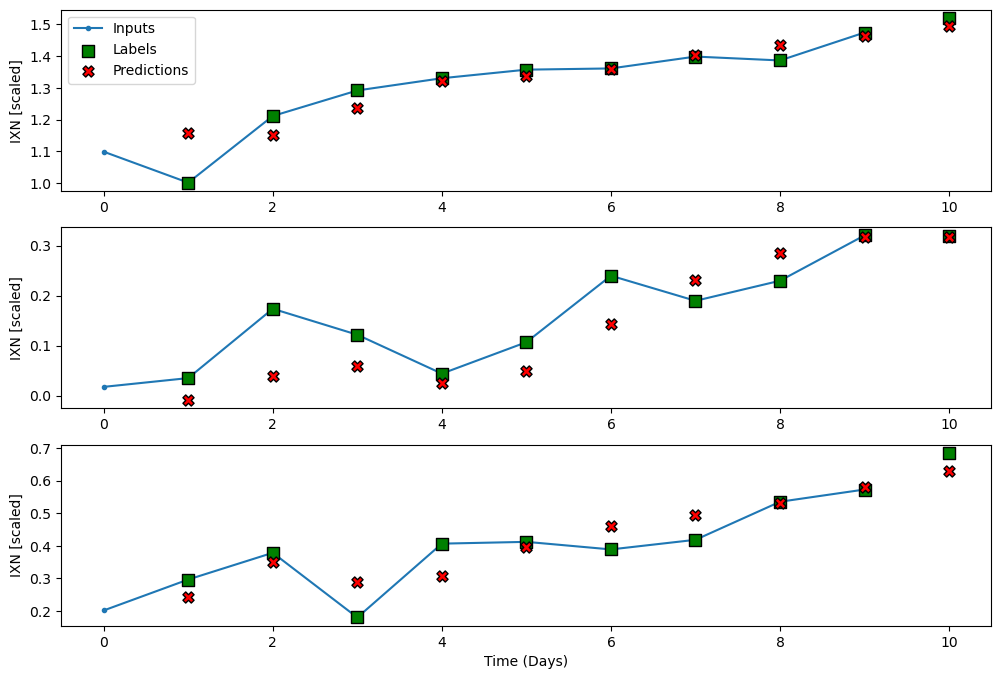

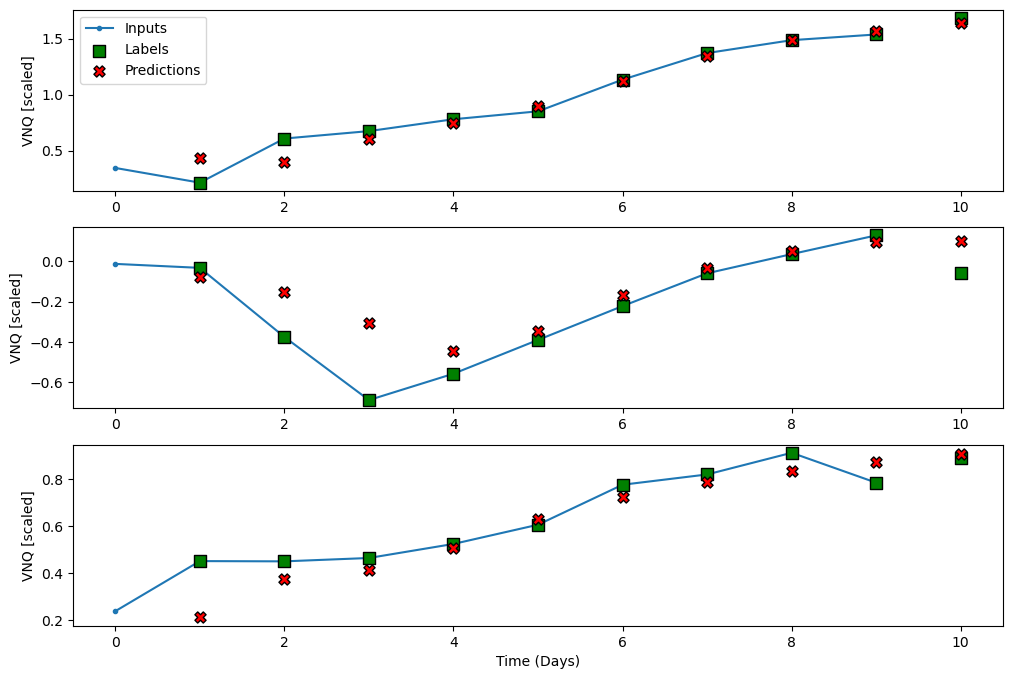

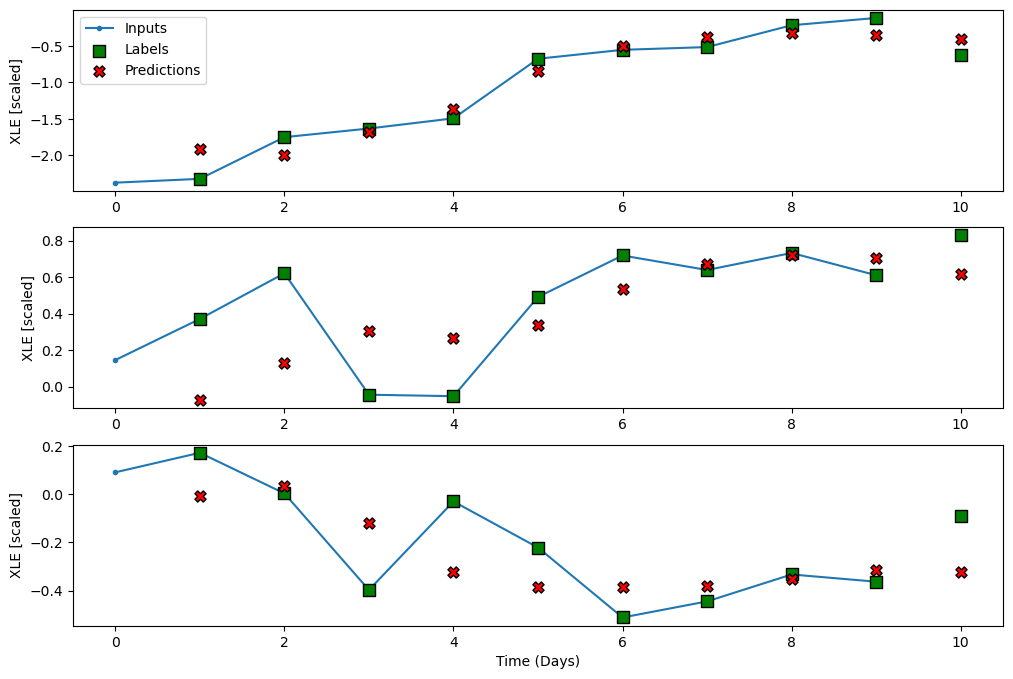

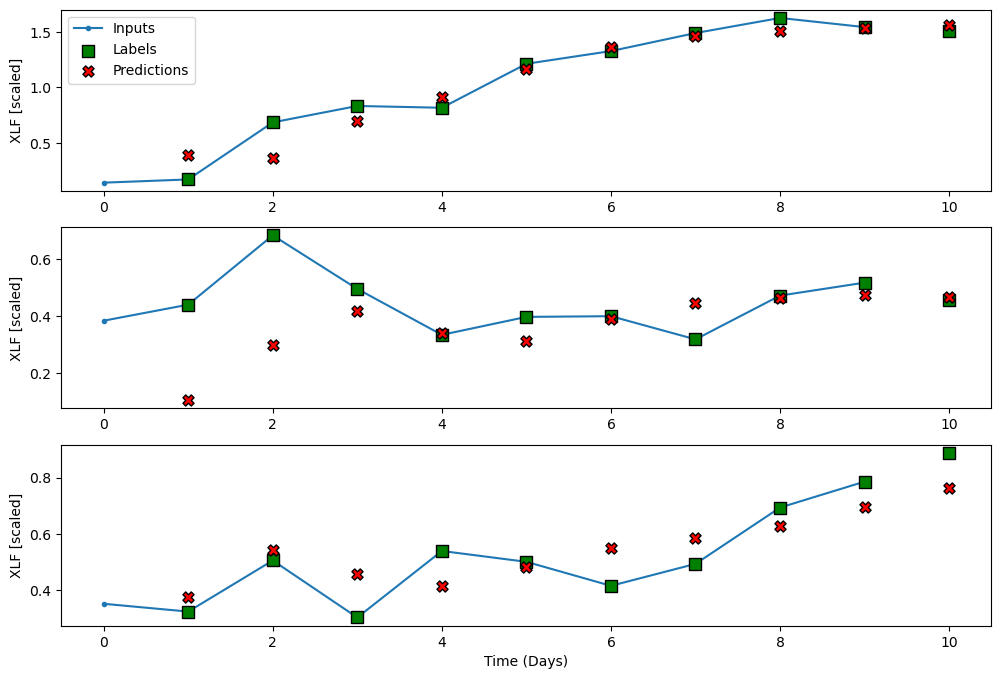

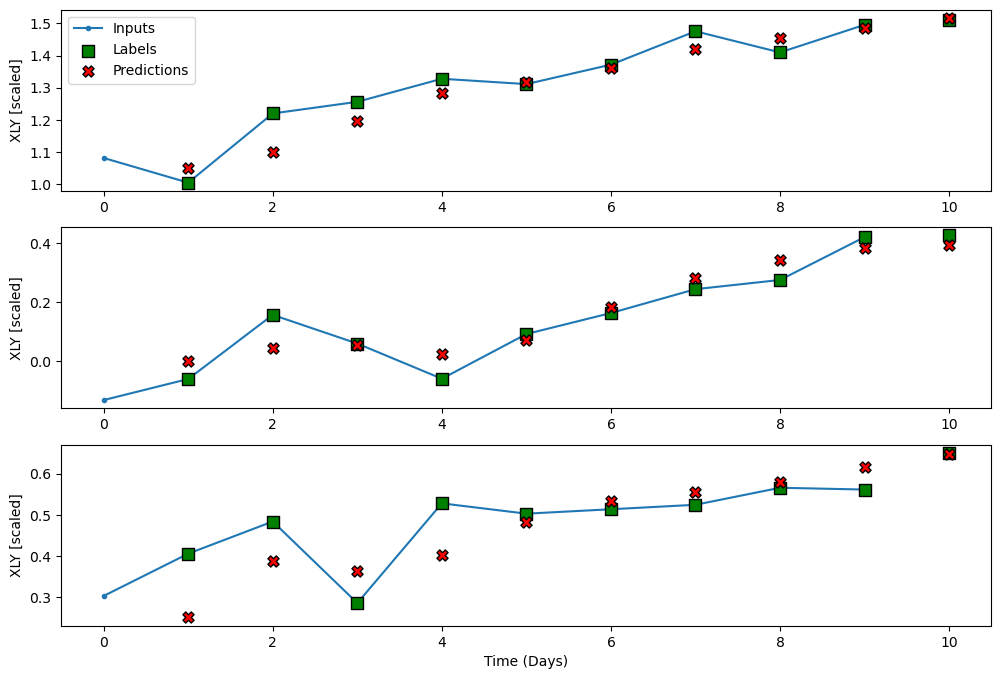

In [30]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='IXN')

mo_wide_window.plot(model=mo_lstm_model, plot_col='VNQ')

mo_wide_window.plot(model=mo_lstm_model, plot_col='XLE')

mo_wide_window.plot(model=mo_lstm_model, plot_col='XLF')

mo_wide_window.plot(model=mo_lstm_model, plot_col='XLY')
# plt.savefig('figures/CH15_F14_peixeiro.png', dpi=300)

In [ ]:
display(mo_lstm_model.evaluate(mo_wide_window.val))